# Downloading DataSet

In [ ]:
#Link of database spectrogram https://drive.google.com/file/d/1mQXwdpNgGdLQfmIzi829e_YsXS3MlJh-/view?usp=sharing
#Link of database mel_spectrogram https://drive.google.com/file/d/1ZEbDtcp4G8oEmQSCpOYPmXMveKiqYh8L/view?usp=sharing
#Downloading Dataset
!gdown https://drive.google.com/uc?id=1mQXwdpNgGdLQfmIzi829e_YsXS3MlJh-
!gdown https://drive.google.com/uc?id=1ZEbDtcp4G8oEmQSCpOYPmXMveKiqYh8L

!unzip spectrogram.zip
!unzip mel_spectrogram.zip


#Loading libraries

In [67]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.utils import np_utils

from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam
from keras.layers import *
from keras.models import Model



# Data Processing and visualization

In [3]:
# Creating Dictionary of label

spec_image_data = []
spec_labels = []

mel_image_data = []
mel_labels = []

combined_image_data = []
combined_labels = []

label_dict = {'MohammedRafi':0, 'ShreyaGhoshal':1, 'SonuNigam':2, 'Hariharan':3, 'KumarSanu':4, 'KishoreKumar':5, 'LataMangeshkar':6, 'MohitChauhan':7, 'Mukesh':8, 'Arijit':9}

In [7]:
# Loading Spectrogram Data
folders = os.listdir('spectrogram')
for ix in folders:
  path = os.path.join('spectrogram',ix)
  for im in os.listdir(path):
    img = image.load_img(os.path.join(path,im),target_size = ((80,80)))
    img_array = image.img_to_array(img)
    spec_image_data.append(img_array)
    spec_labels.append(label_dict[ix])
    combined_image_data.append(img_array)
    combined_labels.append(label_dict[ix])

In [8]:
# Loading Mel Spectrogram Data 

folders = os.listdir('mel_spectrogram')
for ix in folders:
  path = os.path.join('mel_spectrogram',ix)
  for im in os.listdir(path):
    img = image.load_img(os.path.join(path,im),target_size = ((80,80)))
    img_array = image.img_to_array(img)
    mel_image_data.append(img_array)
    mel_labels.append(label_dict[ix])
    combined_image_data.append(img_array)
    combined_labels.append(label_dict[ix])

In [9]:
print(len(spec_image_data))
print(len(spec_labels))

print(len(mel_image_data))
print(len(mel_labels))

print(len(combined_image_data)) 
print(len(combined_labels))

4984
4984
4960
4960
9944
9944


In [10]:
#shuffle the data set

# Spectrogram
combined = list(zip(spec_image_data,spec_labels))
random.shuffle(combined)
spec_image_data[:], spec_labels[:] = zip(*combined)

x_train_spec = np.array(spec_image_data)
y_train_spec = np.array(spec_labels)
#y_train = np_utils.to_categorical(y_train)
print(x_train_spec.shape,y_train_spec.shape)

# Mel_Spectrogram
combined = list(zip(mel_image_data,mel_labels))
random.shuffle(combined)
mel_image_data[:], mel_labels[:] = zip(*combined)

x_train_mel = np.array(mel_image_data)
y_train_mel = np.array(mel_labels)
#y_train = np_utils.to_categorical(y_train)
print(x_train_mel.shape,y_train_mel.shape)


# Combined Data set
combined = list(zip(combined_image_data,combined_labels))
random.shuffle(combined)
combined_image_data[:], combined_labels[:] = zip(*combined)

x_train_combined = np.array(combined_image_data)
y_train_combined = np.array(combined_labels)
#y_train = np_utils.to_categorical(y_train)
print(x_train_combined.shape,y_train_combined.shape)



(4984, 80, 80, 3) (4984,)
(4960, 80, 80, 3) (4960,)
(9944, 80, 80, 3) (9944,)


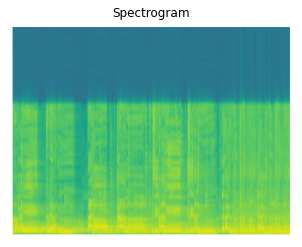

In [11]:
# Visualising Data
img = image.load_img('./spectrogram/Arijit/1.png')
plt.title('Spectrogram')
plt.axis('off')
plt.imshow(img)
plt.show()

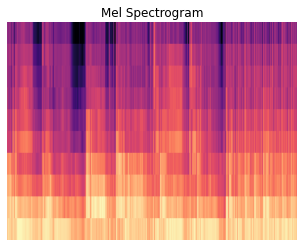

In [12]:
img = image.load_img('./mel_spectrogram/Arijit/1.png')
plt.title('Mel Spectrogram')
plt.axis('off')
plt.imshow(img)
plt.show()

# Feature Extraction

In [15]:
model_VGG = VGG16(include_top=False,weights = 'imagenet',input_shape=(80, 80, 3))
model_Resnet = ResNet50(include_top=False,weights = 'imagenet',input_shape=(80, 80, 3))
model_Inception = InceptionV3(include_top=False,weights = 'imagenet',input_shape=(80, 80, 3))

87916544/87910968 [==============================] - 1s 0us/step


In [16]:
features_VGG = model_VGG.predict(x_train_combined)

In [17]:
features_Resnet = model_Resnet.predict(x_train_combined)

In [18]:
features_Inception = model_Inception.predict(x_train_combined)

In [22]:
features_VGG=features_VGG.reshape(-1,2048)
features_VGG.shape

(9944, 2048)

In [24]:
features_Resnet = features_Resnet.reshape(-1,18432)
features_Resnet.shape

(9944, 18432)

In [26]:
features_Inception = features_Inception.reshape(-1,2048)
features_Inception.shape

(9944, 2048)

# Training Using XG-BOOST

In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, predict_y):
    C = confusion_matrix(y_test, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
   
    
    B =(C/C.sum(axis=0))
   
    labels = [0,1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

In [28]:
seed = 7
test_size = 0.2
X_train_resnet, X_test_resnet, Y_train_resnet, Y_test_resnet = train_test_split(features_Resnet, y_train_combined, test_size=test_size, random_state=seed)
X_train_VGG, X_test_VGG, Y_train_VGG, Y_test_VGG = train_test_split(features_VGG, y_train_combined, test_size=test_size, random_state=seed)
X_train_Inception, X_test_Inception, Y_train_Inception, Y_test_Inception = train_test_split(features_Inception, y_train_combined, test_size=test_size, random_state=seed)

## Using VGG16 

In [29]:
# fit model to training data
model = XGBClassifier()
model.fit(X_train_VGG, Y_train_VGG)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [30]:
# make predictions for test data
y_pred = model.predict(X_test_VGG)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(Y_test_VGG, predictions)
print("Accuracy Using VGG: %.2f%%" % (accuracy * 100.0))

Accuracy Using VGG: 56.41%


-------------------------------------------------- Confusion matrix --------------------------------------------------


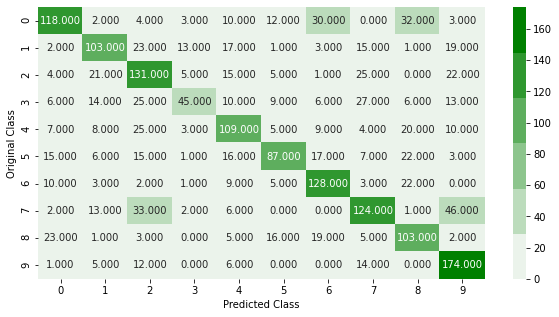

-------------------------------------------------- Precision matrix --------------------------------------------------


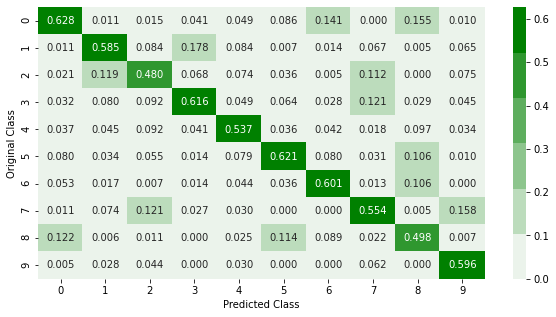

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


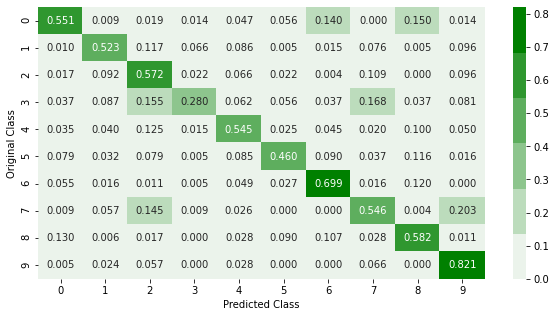

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [43]:
#Plotting Confusion matrix
plot_confusion_matrix(Y_test_VGG,y_pred)

In [48]:
predictions = np.array(model.predict_proba(X_test_VGG))
p = np.argsort(-predictions)

miss_count = 0

hit_top_1 = 0
hit_top_2 = 0
hit_top_3 = 0
hit_top_4 = 0
for  i in range(len(predictions)):
    p1 = p[i][0]
    p2 = p[i][1]
    p3 = p[i][2]
    p4 = p[i][3]
   
    
    if p1 == Y_test_VGG[i]:
        hit_top_1 += 1
       
        
    if p2 == Y_test_VGG[i]:
        hit_top_2 += 1
        
       
    if p3 ==Y_test_VGG[i]:
        hit_top_3 += 1
       
       
    if p4 == Y_test_VGG[i]:
        hit_top_4 += 1
        
        
    else:
        miss_count +=1

hit_top_2 += hit_top_1
hit_top_3 += hit_top_2
hit_top_4 += hit_top_3

top_1_percentage = hit_top_1*100/len(predictions)
top_2_percentage = hit_top_2*100/len(predictions)
top_3_percentage = hit_top_3*100/len(predictions)
top_4_percentage = hit_top_4*100/len(predictions)
print(f"Accuracy @ Top 1 predictions = {top_1_percentage}%")
print(f"Accuracy @ Top 2 predictions = {top_2_percentage}%")
print(f"Accuracy @ Top 3 predictions = {top_3_percentage}%")

Accuracy @ Top 1 predictions = 56.41025641025641%
Accuracy @ Top 2 predictions = 76.26948215183509%
Accuracy @ Top 3 predictions = 86.87782805429865%


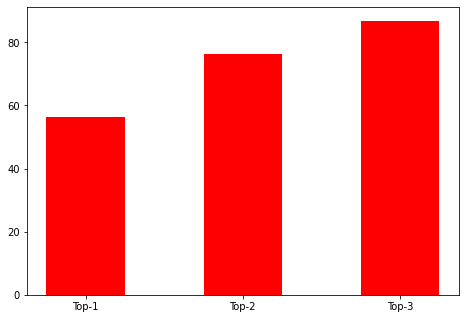

In [60]:
import pandas as pd
x_labels = ["Top-1","Top-2","Top-3"]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
frequencies = [top_1_percentage,top_2_percentage,top_3_percentage]
ax.bar(x_labels,frequencies,color = 'r', width = 0.5)


plt.show()

## Using Resnet50

In [62]:
# fit model to training data
model1 = XGBClassifier()
model1.fit(X_train_resnet, Y_train_resnet)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [82]:
# make predictions for test data
y_pred = model1.predict(X_test_resnet)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(Y_test_resnet, predictions)
print("Accuracy Using ResNet: %.2f%%" % (accuracy * 100.0))

Accuracy Using ResNet: 70.64%


-------------------------------------------------- Confusion matrix --------------------------------------------------


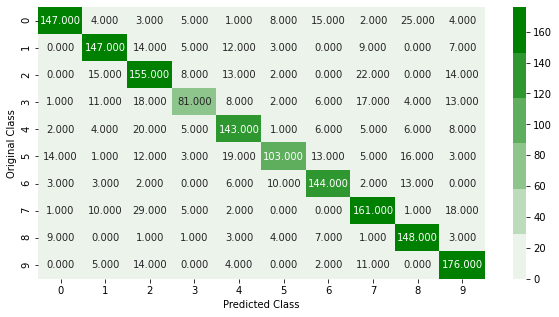

-------------------------------------------------- Precision matrix --------------------------------------------------


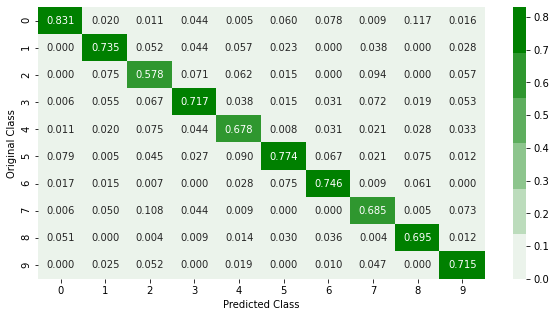

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


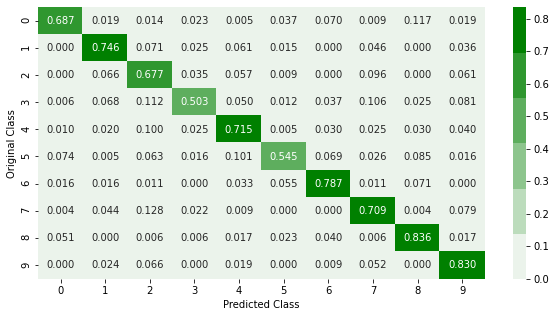

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [70]:
#Plotting Confusion matrix
plot_confusion_matrix(Y_test_resnet,y_pred)

In [72]:
predictions = np.array(model1.predict_proba(X_test_resnet))
p = np.argsort(-predictions)

miss_count = 0

hit_top_1 = 0
hit_top_2 = 0
hit_top_3 = 0
hit_top_4 = 0
for  i in range(len(predictions)):
    p1 = p[i][0]
    p2 = p[i][1]
    p3 = p[i][2]
    p4 = p[i][3]
   
    
    if p1 == Y_test_resnet[i]:
        hit_top_1 += 1
       
        
    if p2 == Y_test_resnet[i]:
        hit_top_2 += 1
        
       
    if p3 ==Y_test_resnet[i]:
        hit_top_3 += 1
       
       
    if p4 == Y_test_resnet[i]:
        hit_top_4 += 1
        
        
    else:
        miss_count +=1

hit_top_2 += hit_top_1
hit_top_3 += hit_top_2
hit_top_4 += hit_top_3

top_1_percentage = hit_top_1*100/len(predictions)
top_2_percentage = hit_top_2*100/len(predictions)
top_3_percentage = hit_top_3*100/len(predictions)
top_4_percentage = hit_top_4*100/len(predictions)
print(f"Accuracy @ Top 1 predictions = {top_1_percentage}%")
print(f"Accuracy @ Top 2 predictions = {top_2_percentage}%")
print(f"Accuracy @ Top 3 predictions = {top_3_percentage}%")

Accuracy @ Top 1 predictions = 70.63851181498241%
Accuracy @ Top 2 predictions = 84.81649069884364%
Accuracy @ Top 3 predictions = 93.06184012066365%


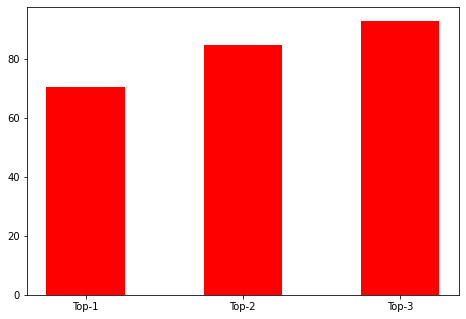

In [73]:
import pandas as pd
x_labels = ["Top-1","Top-2","Top-3"]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
frequencies = [top_1_percentage,top_2_percentage,top_3_percentage]
ax.bar(x_labels,frequencies,color = 'r', width = 0.5)


plt.show()

##Using Inception

In [65]:
# fit model to training data
model2 = XGBClassifier()
model2.fit(X_train_Inception, Y_train_Inception)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [83]:
# make predictions for test data
y_pred = model2.predict(X_test_Inception)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(Y_test_Inception, predictions)
print("Accuracy Using Inception: %.2f%%" % (accuracy * 100.0))

Accuracy Using Inception: 56.26%


-------------------------------------------------- Confusion matrix --------------------------------------------------


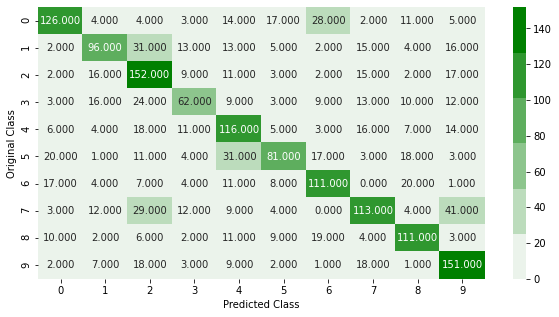

-------------------------------------------------- Precision matrix --------------------------------------------------


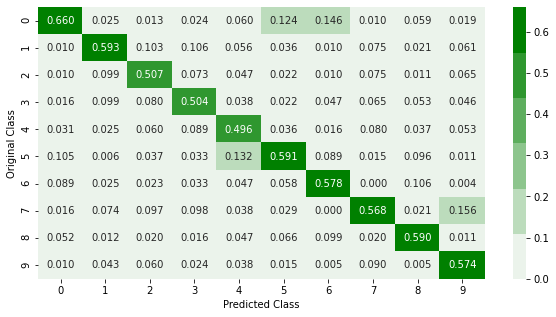

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


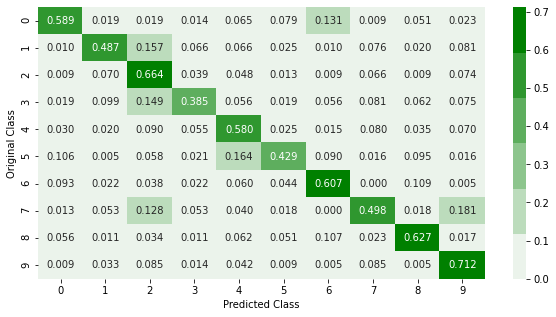

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [77]:
#Plotting Confusion matrix
plot_confusion_matrix(Y_test_Inception,y_pred)

In [80]:
predictions = np.array(model2.predict_proba(X_test_Inception))
p = np.argsort(-predictions)

miss_count = 0

hit_top_1 = 0
hit_top_2 = 0
hit_top_3 = 0
hit_top_4 = 0
for  i in range(len(predictions)):
    p1 = p[i][0]
    p2 = p[i][1]
    p3 = p[i][2]
    p4 = p[i][3]
   
    
    if p1 == Y_test_Inception[i]:
        hit_top_1 += 1
       
        
    if p2 == Y_test_Inception[i]:
        hit_top_2 += 1
        
       
    if p3 ==Y_test_Inception[i]:
        hit_top_3 += 1
       
       
    if p4 == Y_test_Inception[i]:
        hit_top_4 += 1
        
        
    else:
        miss_count +=1

hit_top_2 += hit_top_1
hit_top_3 += hit_top_2
hit_top_4 += hit_top_3

top_1_percentage = hit_top_1*100/len(predictions)
top_2_percentage = hit_top_2*100/len(predictions)
top_3_percentage = hit_top_3*100/len(predictions)
top_4_percentage = hit_top_4*100/len(predictions)
print(f"Accuracy @ Top 1 predictions = {top_1_percentage}%")
print(f"Accuracy @ Top 2 predictions = {top_2_percentage}%")
print(f"Accuracy @ Top 3 predictions = {top_3_percentage}%")

Accuracy @ Top 1 predictions = 56.25942684766214%
Accuracy @ Top 2 predictions = 76.01809954751131%
Accuracy @ Top 3 predictions = 85.41980894922071%


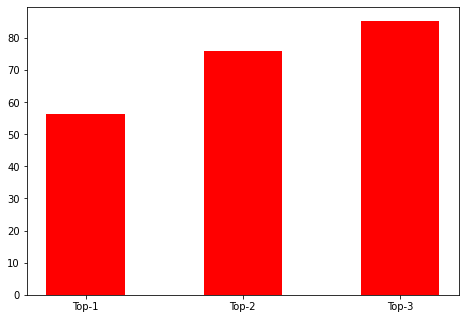

In [81]:
import pandas as pd
x_labels = ["Top-1","Top-2","Top-3"]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
frequencies = [top_1_percentage,top_2_percentage,top_3_percentage]
ax.bar(x_labels,frequencies,color = 'r', width = 0.5)


plt.show()

# Example

In [ ]:
# Downloading mp3 song
# Link to song https://drive.google.com/file/d/1S6U_LSdrKEFxQeSB9YPc5i_ZDZkclDpd/view?usp=sharing
!gdown https://drive.google.com/uc?id=1S6U_LSdrKEFxQeSB9YPc5i_ZDZkclDpd
!unzip ExampleData.zip

In [ ]:
!pip install pydub
!pip install librosa
!pip install pylab

import os
import numpy as np
import scipy.io.wavfile
import matplotlib.pyplot as plt
from pydub import AudioSegment


import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt

import pylab

In [ ]:
labels_dict = {9:'Arijit',
 3:'Hariharan',
 5:'KishoreKumar',
 4:'KumarSanu',
 6:'LataMangeshkar',
 0:'MohammedRafi',
 7:'MohitChauhan',
 8:'Mukesh',
 1:'ShreyaGhoshal',
 2:'SonuNigam'}

## Example 1 :  
Song : Woh Din 

Artist : Arijit Singh

In [94]:
# Converting mp3 to wav
song = AudioSegment.from_mp3('/content/ExampleData/WohDin.mp3')
song.export('/content/ExampleData/WohDin.wav','wav')

<_io.BufferedRandom name='/content/ExampleData/WohDin.wav'>

In [96]:
# Saving Mel Spectrogram
rate, X = scipy.io.wavfile.read('/content/ExampleData/WohDin.wav')
Y = np.mean(X, axis=1)
mel_spectrogram = librosa.feature.melspectrogram(Y, sr=rate, n_fft=2048, hop_length=512, n_mels=10)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
pylab.axis('off') 
pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
librosa.display.specshow(log_mel_spectrogram, sr=rate)
pylab.savefig('/content/ExampleData/WohDin.png', bbox_inches=None, pad_inches=0)
pylab.close()

In [111]:
# Loading Mel Spectrogram Image
img = image.load_img('/content/ExampleData/WohDin.png',target_size = ((80,80)))
img_array = image.img_to_array(img)

In [112]:
img_array =img_array.reshape(-1,80,80,3)
img_array.shape

(1, 80, 80, 3)

In [116]:
# Prediction
a = model_Resnet.predict(img_array)
a = a.reshape(-1,18432)

predictions = np.array(model1.predict_proba(a))

In [137]:

count = 0
result = []
sort_pred = sorted(list(predictions[0]), reverse =True)

for i in range(3):
  for j in range(len(predictions[0])):
    if(sort_pred[i]==predictions[0][j]):
      result.append(labels_dict[j])
print('Predicted Top3 Result: ',result)

Predicted Top3 Result:  ['Arijit', 'MohitChauhan', 'ShreyaGhoshal']


## Example 2 :  
Song : Abhi Mujh Mein Kahin

Artist : Sonu Nigam

In [138]:
# Converting mp3 to wav
song = AudioSegment.from_mp3('/content/ExampleData/AbhiMujhMeinKahin.mp3')
song.export('/content/ExampleData/AbhiMujhMeinKahin.wav','wav')

<_io.BufferedRandom name='/content/ExampleData/AbhiMujhMeinKahin.wav'>

In [139]:
# Saving Mel Spectrogram
rate, X = scipy.io.wavfile.read('/content/ExampleData/AbhiMujhMeinKahin.wav')
Y = np.mean(X, axis=1)
mel_spectrogram = librosa.feature.melspectrogram(Y, sr=rate, n_fft=2048, hop_length=512, n_mels=10)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
pylab.axis('off') 
pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
librosa.display.specshow(log_mel_spectrogram, sr=rate)
pylab.savefig('/content/ExampleData/AbhiMujhMeinKahin.png', bbox_inches=None, pad_inches=0)
pylab.close()

In [142]:
# Loading Mel Spectrogram Image
img = image.load_img('/content/ExampleData/AbhiMujhMeinKahin.png',target_size = ((80,80)))
img_array = image.img_to_array(img)

img_array =img_array.reshape(-1,80,80,3)
img_array.shape

a = model_Resnet.predict(img_array)
a = a.reshape(-1,18432)

predictions = np.array(model1.predict_proba(a))

count = 0
result = []
sort_pred = sorted(list(predictions[0]), reverse =True)

for i in range(3):
  for j in range(len(predictions[0])):
    if(sort_pred[i]==predictions[0][j]):
      result.append(labels_dict[j])
print('Predicted Top3 Result: ',result)

Predicted Top3 Result:  ['MohitChauhan', 'SonuNigam', 'Hariharan']
